<a href="https://colab.research.google.com/github/Samy-Annasri/ReverseForecastAttack/blob/main/ReverseForecastAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORT

In [109]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [110]:
import sys
import os

def in_colab():
    return 'google.colab' in sys.modules

if in_colab():
    repo_name = "ReverseForecastAttack"
    ipynb_name = "ReverseForecastAttack.ipynb"
    cwd = os.getcwd()
    basename = os.path.basename(cwd)

    if basename != repo_name:
        if not os.path.exists(repo_name):
            !git clone https://github.com/Samy-Annasri/ReverseForecastAttack.git
        %cd {repo_name}
        %rm {ipynb_name}



In [111]:
'''
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
'''

"\ndef set_seed(seed=42):\n    random.seed(seed)\n    np.random.seed(seed)\n    torch.manual_seed(seed)\n    torch.cuda.manual_seed_all(seed)\n    os.environ['PYTHONHASHSEED'] = str(seed)\n    torch.backends.cudnn.deterministic = True\n    torch.backends.cudnn.benchmark = False\n\nset_seed(42)\n"

In [112]:
# just some code for testing the import
'''
import sys

if 'prepare_stock_dataset' in globals():
    del globals()['prepare_stock_dataset']

module_name = 'utils.setup_google_stock_dataset'
if module_name in sys.modules:
    del sys.modules[module_name]
'''

"\nimport sys\n\nif 'prepare_stock_dataset' in globals():\n    del globals()['prepare_stock_dataset']\n\nmodule_name = 'utils.setup_google_stock_dataset'\nif module_name in sys.modules:\n    del sys.modules[module_name]\n"

## STEP 1: PREP DATA

In [113]:
google_data = pd.read_csv("data/HistoricalData_1747091015337.csv")
google_data['Date'] = pd.to_datetime(google_data['Date'])
google_data = google_data.sort_values(by='Date')
display(google_data)

,Date,Close/Last,Volume,Open,High,Low
1254,2020-05-13,$67.4665,36251700,$68.8525,$69.2741,$66.42
1253,2020-05-14,$67.8065,32061540,$66.751,$67.871,$66.1955
1252,2020-05-15,$68.6595,34154940,$67.50,$68.724,$66.95
1251,2020-05-18,$69.197,36479280,$68.0875,$69.6163,$67.7125
1250,2020-05-19,$68.6743,25612980,$69.3499,$69.60,$68.6743
...,...,...,...,...,...,...
4,2025-05-05,$166.05,15309340,$164.515,$167.10,$164.47
3,2025-05-06,$165.20,10691950,$163.96,$166.74,$163.13
2,2025-05-07,$152.80,78900430,$166.07,$166.99,$149.4901
1,2025-05-08,$155.75,38387510,$155.92,$157.41,$154.10


In [114]:
from utils.setup_google_stock_dataset import prepare_stock_dataset
sequence_length = 30
result = prepare_stock_dataset(google_data)

train_loader = result['train_loader']
test_loader = result['test_loader']
train_size = result['train_size']
min_max = result['min_max']
dates = result['dates']
price_min, price_max = min_max['Close/Last']


## STEP 2: TRAIN NORMAL LSTM

In [115]:
from utils.train_model import train_model
from models.lstm import SimpleLSTM
model_google = SimpleLSTM(input_size=5, hidden_size=64, output_size=1, num_layers=2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_google.parameters(), lr=0.001)
num_epochs = 30
train_model(model_google, loss_fn, optimizer, num_epochs, train_loader)

Epoch [1/30], Train Loss: 0.0444
Epoch [2/30], Train Loss: 0.0086
Epoch [3/30], Train Loss: 0.0017
Epoch [4/30], Train Loss: 0.0013
Epoch [5/30], Train Loss: 0.0010
Epoch [6/30], Train Loss: 0.0010
Epoch [7/30], Train Loss: 0.0010
Epoch [8/30], Train Loss: 0.0009
Epoch [9/30], Train Loss: 0.0009
Epoch [10/30], Train Loss: 0.0009
Epoch [11/30], Train Loss: 0.0008
Epoch [12/30], Train Loss: 0.0009
Epoch [13/30], Train Loss: 0.0008
Epoch [14/30], Train Loss: 0.0008
Epoch [15/30], Train Loss: 0.0009
Epoch [16/30], Train Loss: 0.0009
Epoch [17/30], Train Loss: 0.0009
Epoch [18/30], Train Loss: 0.0008
Epoch [19/30], Train Loss: 0.0009
Epoch [20/30], Train Loss: 0.0009
Epoch [21/30], Train Loss: 0.0008
Epoch [22/30], Train Loss: 0.0007
Epoch [23/30], Train Loss: 0.0008
Epoch [24/30], Train Loss: 0.0008
Epoch [25/30], Train Loss: 0.0007
Epoch [26/30], Train Loss: 0.0007
Epoch [27/30], Train Loss: 0.0008
Epoch [28/30], Train Loss: 0.0008
Epoch [29/30], Train Loss: 0.0007
Epoch [30/30], Train Lo

In [116]:
from utils.google_eval import evaluate_model_google
results = evaluate_model_google(model_google, test_loader, dates, train_size)

real_values = results['real_values']
predicted_values = results['predicted_values']
test_dates = results['test_dates']

In [117]:
# Computes scalar similarity (cosine similarity) between true and predicted values.
# Higher values indicate that adversarial predictions remain directionally aligned
# with the true values, suggesting stealthy and rational attacks!
def scalar_similarity(y_true, y_pred):
    numerator = np.dot(y_true, y_pred)
    denominator = np.linalg.norm(y_true) * np.linalg.norm(y_pred)
    if denominator == 0:
        return 0.0
    return numerator / denominator

In [118]:
# Creation of the tab result for plotting adversial attack result
models = ['LSTM','RNN','GRU']
metrics = ['MAE', "RMSE", 'SIM']

row_index = pd.MultiIndex.from_product([models, metrics], names=['Model', 'Metric'])

attacks = ['NA','PAST','REV']
epsilons = {
    'NA': [0],
    'PAST':[0],
    'REV':[0.01,0.05,0.1,0.2],
}

col_tuples = []
for atk, eps_list in epsilons.items():
    for eps in eps_list:
        col_tuples.append((atk, f"{eps:.2f}"))

col_index = pd.MultiIndex.from_tuples(col_tuples, names=['Attack', 'ε'])

res_tab = pd.DataFrame(index=row_index, columns=col_index, dtype=float)

print(res_tab)

Attack         NA PAST  REV               
ε            0.00 0.00 0.01 0.05 0.10 0.20
Model Metric                              
LSTM  MAE     NaN  NaN  NaN  NaN  NaN  NaN
      RMSE    NaN  NaN  NaN  NaN  NaN  NaN
      SIM     NaN  NaN  NaN  NaN  NaN  NaN
RNN   MAE     NaN  NaN  NaN  NaN  NaN  NaN
      RMSE    NaN  NaN  NaN  NaN  NaN  NaN
      SIM     NaN  NaN  NaN  NaN  NaN  NaN
GRU   MAE     NaN  NaN  NaN  NaN  NaN  NaN
      RMSE    NaN  NaN  NaN  NaN  NaN  NaN
      SIM     NaN  NaN  NaN  NaN  NaN  NaN


LSTM | NA – Epsilon 0.00 – MAE: 5.0187 | SIM: 0.9996


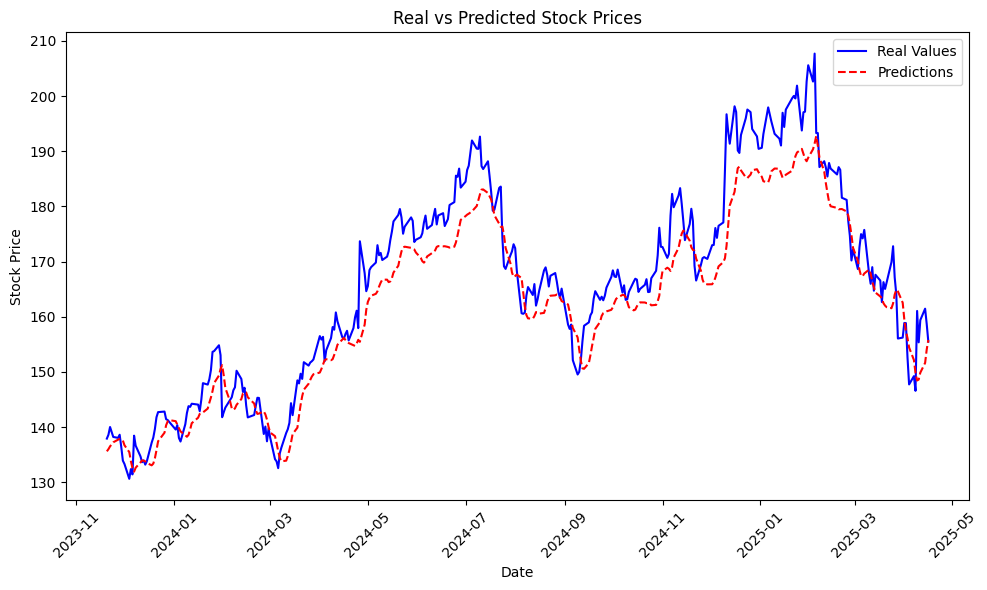

In [119]:
from utils.log_and_plot import log_and_plot_predictions
# Denormalize
true_values_denorm = real_values * (price_max - price_min) + price_min
predictions_denorm = predicted_values * (price_max - price_min) + price_min

log_and_plot_predictions(
    true_values=true_values_denorm,
    predictions=predictions_denorm,
    test_dates=test_dates,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='LSTM',
    attack_name='NA',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True
)

In [120]:
display(res_tab)

Attack              NA PAST  REV               
ε                 0.00 0.00 0.01 0.05 0.10 0.20
Model Metric                                   
LSTM  MAE     5.018705  NaN  NaN  NaN  NaN  NaN
      RMSE    6.179676  NaN  NaN  NaN  NaN  NaN
      SIM     0.999626  NaN  NaN  NaN  NaN  NaN
RNN   MAE          NaN  NaN  NaN  NaN  NaN  NaN
      RMSE         NaN  NaN  NaN  NaN  NaN  NaN
      SIM          NaN  NaN  NaN  NaN  NaN  NaN
GRU   MAE          NaN  NaN  NaN  NaN  NaN  NaN
      RMSE         NaN  NaN  NaN  NaN  NaN  NaN
      SIM          NaN  NaN  NaN  NaN  NaN  NaN

## STEP 3: REVERSE DATA

In [121]:
from utils.setup_google_stock_dataset import prepare_stock_dataset
google_data_reversed = google_data
result_rev = prepare_stock_dataset(google_data_reversed,reverse=True)
train_loader_rev = result_rev['train_loader']
test_loader_rev = result_rev['test_loader']
train_size_rev = result['train_size']
min_max_rev = result['min_max']
dates_rev = result_rev['dates']
price_min_rev, price_max_rev = min_max['Close/Last']


## STEP 4: TRAIN REVERSE LSTM

In [122]:
model_google_rev = SimpleLSTM(input_size=5, hidden_size=64, output_size=1, num_layers=2)
optimizer_rev = torch.optim.Adam(model_google_rev.parameters(), lr=0.001)

train_model(model_google_rev, loss_fn, optimizer_rev, num_epochs, train_loader_rev)

Epoch [1/30], Train Loss: 0.0380
Epoch [2/30], Train Loss: 0.0050
Epoch [3/30], Train Loss: 0.0014
Epoch [4/30], Train Loss: 0.0010
Epoch [5/30], Train Loss: 0.0009
Epoch [6/30], Train Loss: 0.0008
Epoch [7/30], Train Loss: 0.0008
Epoch [8/30], Train Loss: 0.0007
Epoch [9/30], Train Loss: 0.0008
Epoch [10/30], Train Loss: 0.0008
Epoch [11/30], Train Loss: 0.0007
Epoch [12/30], Train Loss: 0.0009
Epoch [13/30], Train Loss: 0.0009
Epoch [14/30], Train Loss: 0.0008
Epoch [15/30], Train Loss: 0.0007
Epoch [16/30], Train Loss: 0.0007
Epoch [17/30], Train Loss: 0.0007
Epoch [18/30], Train Loss: 0.0007
Epoch [19/30], Train Loss: 0.0006
Epoch [20/30], Train Loss: 0.0006
Epoch [21/30], Train Loss: 0.0006
Epoch [22/30], Train Loss: 0.0006
Epoch [23/30], Train Loss: 0.0006
Epoch [24/30], Train Loss: 0.0006
Epoch [25/30], Train Loss: 0.0006
Epoch [26/30], Train Loss: 0.0005
Epoch [27/30], Train Loss: 0.0005
Epoch [28/30], Train Loss: 0.0005
Epoch [29/30], Train Loss: 0.0005
Epoch [30/30], Train Lo

LSTM | PAST – Epsilon 0.00 – MAE: 3.0848 | SIM: 0.9997


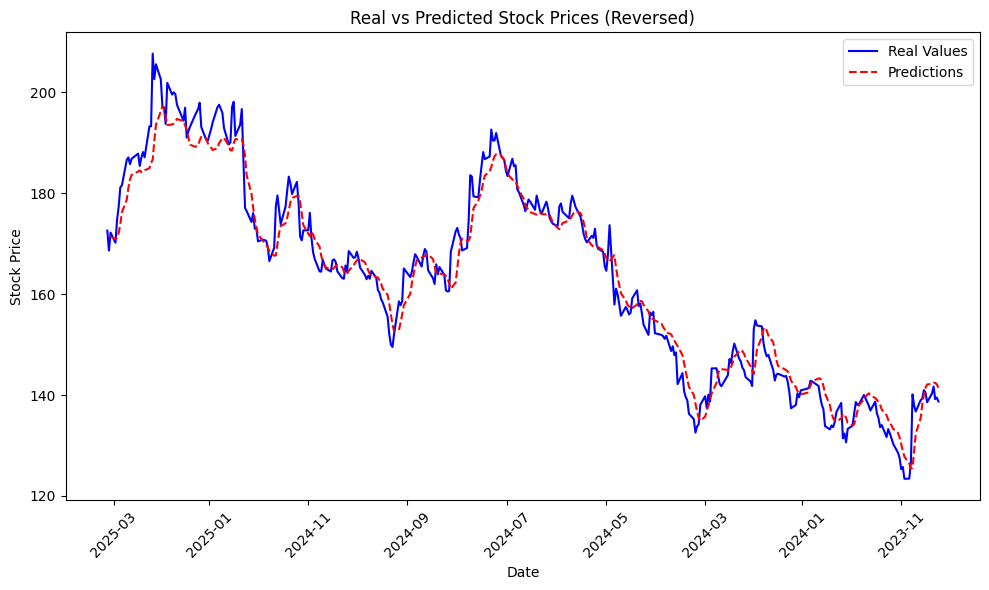

In [123]:
results_rev = evaluate_model_google(model_google_rev, test_loader_rev, dates_rev, train_size_rev)

real_values_rev = results_rev['real_values']
predicted_values_rev = results_rev['predicted_values']
test_dates_rev = results_rev['test_dates']

min_len = min(len(test_dates_rev), len(real_values_rev), len(predicted_values_rev))
true_values_denorm_rev = (real_values_rev * (price_max_rev - price_min_rev) + price_min_rev)[:min_len]
predictions_denorm_rev = (predicted_values_rev * (price_max_rev - price_min_rev) + price_min_rev)[:min_len]
test_dates_rev = test_dates_rev[:min_len]

log_and_plot_predictions(
    true_values=true_values_denorm_rev,
    predictions=predictions_denorm_rev,
    test_dates=test_dates_rev,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='LSTM',
    attack_name='PAST',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True,
    reverse=True
)

# STEP 5: ATTACK FGSM NO AUTOREGRESSIVELY (FIRST ATTEMPT)

In [124]:
from scipy.stats import ks_2samp

def ks_test(preds_clean, preds_adv):
    stat, p_value = ks_2samp(preds_clean, preds_adv)
    return stat, p_value

!pip install fastdtw
from fastdtw import fastdtw
from scipy.stats import pearsonr

def dtw_distance(ts1, ts2):
    distance, _ = fastdtw(ts1, ts2)
    return distance

def correlation(ts1, ts2):
    return pearsonr(ts1, ts2)[0]

def fft_difference(ts1, ts2):
  fft1 = np.abs(np.fft.fft(ts1))
  fft2 = np.abs(np.fft.fft(ts2))
  return np.mean(np.abs(fft1 - fft2))

LSTM | REV – Epsilon 0.01 – MAE: 5.0722 | SIM: 0.9996


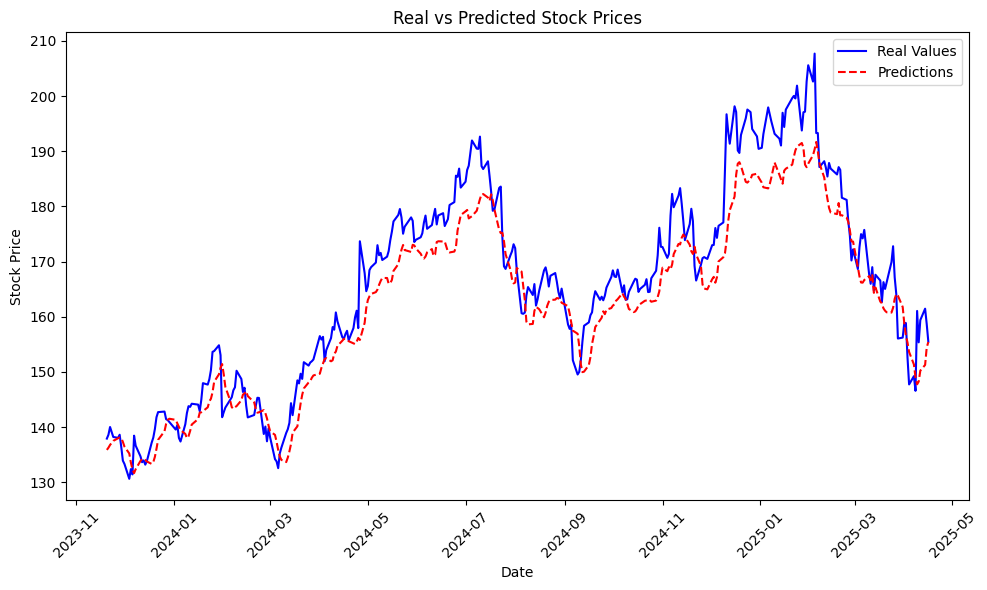

LSTM | REV – Epsilon 0.05 – MAE: 5.8425 | SIM: 0.9994


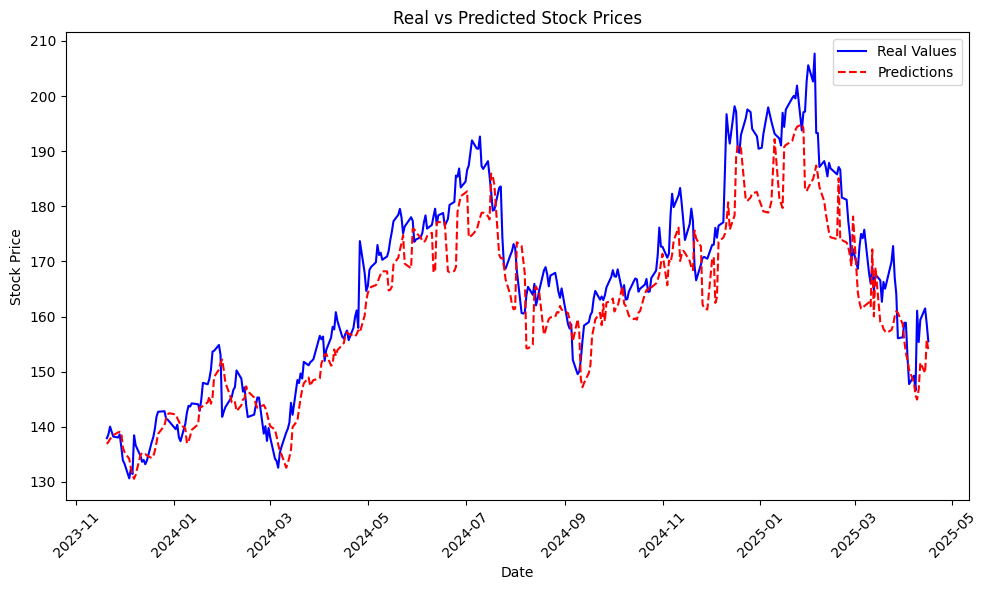

LSTM | REV – Epsilon 0.10 – MAE: 7.6204 | SIM: 0.9988


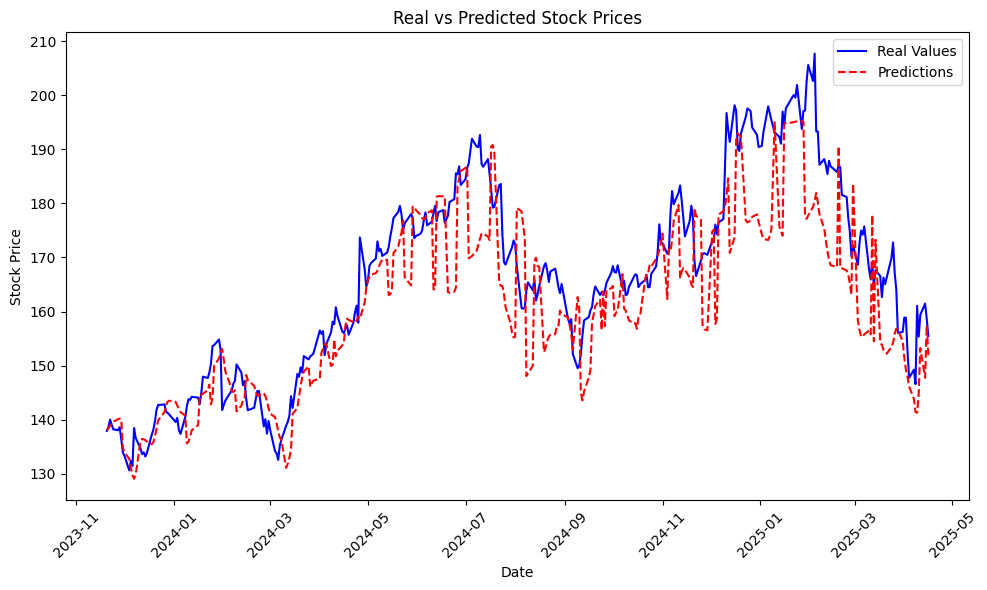

LSTM | REV – Epsilon 0.20 – MAE: 12.5513 | SIM: 0.9962


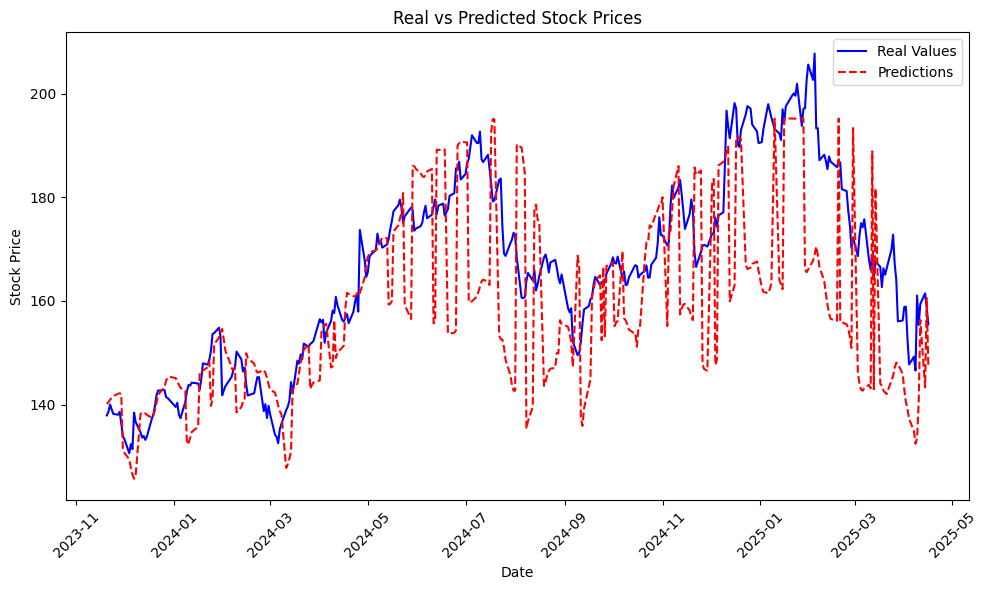

In [125]:
from attack.rev import reverse_forecast_attack

epsilons = [0.01, 0.05, 0.1, 0.2]
results = reverse_forecast_attack(
    model_google_rev, model_google,
    test_loader_rev, test_loader,
    epsilons,
    price_min, price_max
)

for esp, (true_vals, preds) in results.items():
  log_and_plot_predictions(
      true_values=true_vals,
      predictions=preds,
      test_dates=test_dates,
      true_values_rolling=None,
      predictions_rolling=None,
      model_name='LSTM',
      attack_name='REV',
      epsilon=esp,
      res_tab=res_tab,
      similarity_fn=scalar_similarity,
      google=True
  )

In [126]:
display(res_tab)

Attack              NA      PAST       REV                               
ε                 0.00      0.00      0.01      0.05      0.10       0.20
Model Metric                                                             
LSTM  MAE     5.018705  3.084825  5.072169  5.842518  7.620422  12.551338
      RMSE    6.179676  4.066869  6.284750  7.415823  9.891750  16.168176
      SIM     0.999626  0.999701  0.999619  0.999412  0.998756   0.996163
RNN   MAE          NaN       NaN       NaN       NaN       NaN        NaN
      RMSE         NaN       NaN       NaN       NaN       NaN        NaN
      SIM          NaN       NaN       NaN       NaN       NaN        NaN
GRU   MAE          NaN       NaN       NaN       NaN       NaN        NaN
      RMSE         NaN       NaN       NaN       NaN       NaN        NaN
      SIM          NaN       NaN       NaN       NaN       NaN        NaN

## STEP 5 FOR OTHER MODELS (RNN,CNN)

In [127]:
from utils.train_model import train_model
from models.rnn import SimpleRNN
model_google_rnn = SimpleRNN(input_size=5, hidden_size=64, output_size=1, num_layers=2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_google_rnn.parameters(), lr=0.001)
num_epochs = 30
train_model(model_google_rnn, loss_fn, optimizer, num_epochs, train_loader)

Epoch [1/30], Train Loss: 0.0286
Epoch [2/30], Train Loss: 0.0015
Epoch [3/30], Train Loss: 0.0006
Epoch [4/30], Train Loss: 0.0006
Epoch [5/30], Train Loss: 0.0005
Epoch [6/30], Train Loss: 0.0005
Epoch [7/30], Train Loss: 0.0005
Epoch [8/30], Train Loss: 0.0005
Epoch [9/30], Train Loss: 0.0004
Epoch [10/30], Train Loss: 0.0004
Epoch [11/30], Train Loss: 0.0004
Epoch [12/30], Train Loss: 0.0005
Epoch [13/30], Train Loss: 0.0004
Epoch [14/30], Train Loss: 0.0004
Epoch [15/30], Train Loss: 0.0004
Epoch [16/30], Train Loss: 0.0004
Epoch [17/30], Train Loss: 0.0004
Epoch [18/30], Train Loss: 0.0004
Epoch [19/30], Train Loss: 0.0004
Epoch [20/30], Train Loss: 0.0003
Epoch [21/30], Train Loss: 0.0003
Epoch [22/30], Train Loss: 0.0004
Epoch [23/30], Train Loss: 0.0004
Epoch [24/30], Train Loss: 0.0003
Epoch [25/30], Train Loss: 0.0003
Epoch [26/30], Train Loss: 0.0003
Epoch [27/30], Train Loss: 0.0003
Epoch [28/30], Train Loss: 0.0003
Epoch [29/30], Train Loss: 0.0004
Epoch [30/30], Train Lo

RNN | NA – Epsilon 0.00 – MAE: 5.4171 | SIM: 0.9998


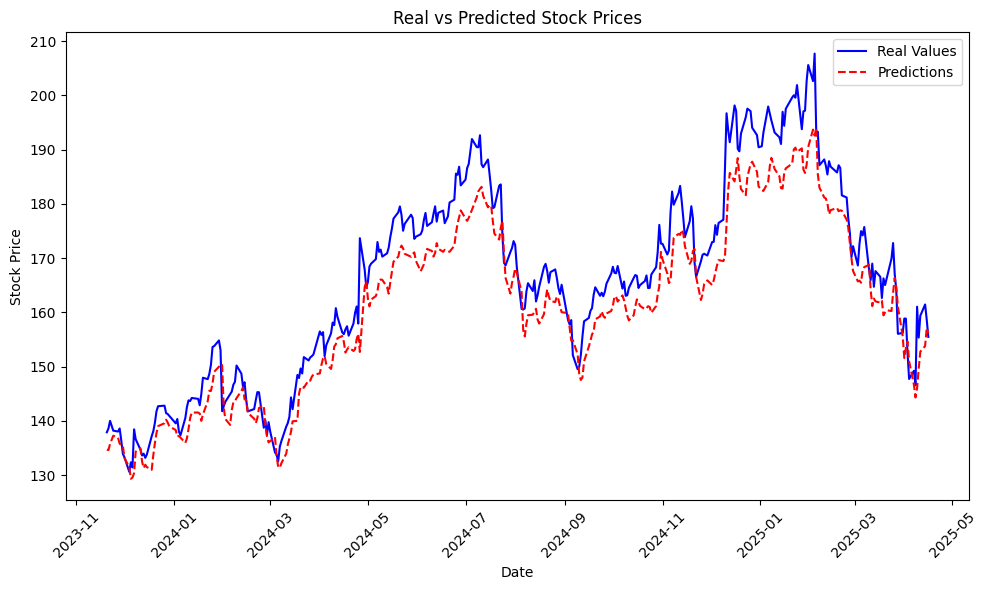

In [128]:
results_rnn = evaluate_model_google(model_google_rnn, test_loader, dates, train_size)

real_values_rnn = results_rnn['real_values']
predicted_values_rnn = results_rnn['predicted_values']
test_dates = results_rnn['test_dates']

true_values_denorm_rnn = real_values_rnn * (price_max - price_min) + price_min
predictions_denorm_rnn = predicted_values_rnn * (price_max - price_min) + price_min

log_and_plot_predictions(
    true_values=true_values_denorm_rnn,
    predictions=predictions_denorm_rnn,
    test_dates=test_dates,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='RNN',
    attack_name='NA',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True
)

In [129]:
model_google_rnn_rev = SimpleRNN(input_size=5, hidden_size=64, output_size=1, num_layers=2)
optimizer_rev = torch.optim.Adam(model_google_rnn_rev.parameters(), lr=0.001)

train_model(model_google_rnn_rev, loss_fn, optimizer_rev, num_epochs, train_loader_rev)

Epoch [1/30], Train Loss: 0.0242
Epoch [2/30], Train Loss: 0.0016
Epoch [3/30], Train Loss: 0.0006
Epoch [4/30], Train Loss: 0.0004
Epoch [5/30], Train Loss: 0.0004
Epoch [6/30], Train Loss: 0.0004
Epoch [7/30], Train Loss: 0.0004
Epoch [8/30], Train Loss: 0.0003
Epoch [9/30], Train Loss: 0.0003
Epoch [10/30], Train Loss: 0.0003
Epoch [11/30], Train Loss: 0.0003
Epoch [12/30], Train Loss: 0.0002
Epoch [13/30], Train Loss: 0.0002
Epoch [14/30], Train Loss: 0.0002
Epoch [15/30], Train Loss: 0.0002
Epoch [16/30], Train Loss: 0.0002
Epoch [17/30], Train Loss: 0.0003
Epoch [18/30], Train Loss: 0.0002
Epoch [19/30], Train Loss: 0.0002
Epoch [20/30], Train Loss: 0.0002
Epoch [21/30], Train Loss: 0.0002
Epoch [22/30], Train Loss: 0.0002
Epoch [23/30], Train Loss: 0.0002
Epoch [24/30], Train Loss: 0.0002
Epoch [25/30], Train Loss: 0.0002
Epoch [26/30], Train Loss: 0.0002
Epoch [27/30], Train Loss: 0.0002
Epoch [28/30], Train Loss: 0.0002
Epoch [29/30], Train Loss: 0.0002
Epoch [30/30], Train Lo

RNN | PAST – Epsilon 0.00 – MAE: 3.3781 | SIM: 0.9998


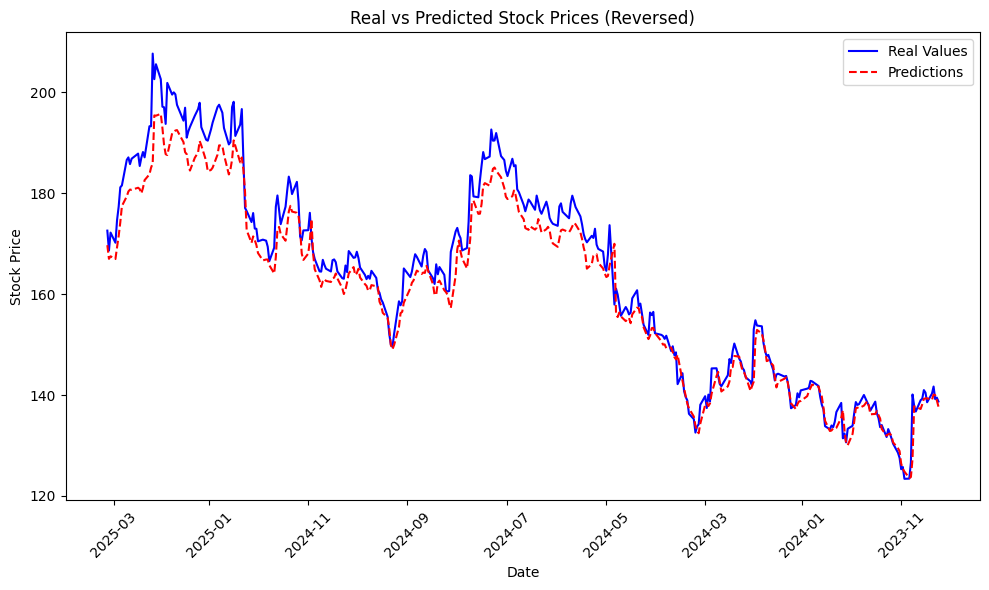

In [130]:
results_rnn_rev = evaluate_model_google(model_google_rnn_rev, test_loader_rev, dates_rev, train_size_rev)

real_values_rnn_rev = results_rnn_rev['real_values']
predicted_values_rnn_rev = results_rnn_rev['predicted_values']
test_dates_rev = results_rnn_rev['test_dates']

min_len = min(len(test_dates_rev), len(real_values_rnn_rev), len(predicted_values_rnn_rev))
true_values_denorm_rnn_rev = (real_values_rnn_rev * (price_max_rev - price_min_rev) + price_min_rev)[:min_len]
predictions_denorm_rnn_rev = (predicted_values_rnn_rev * (price_max_rev - price_min_rev) + price_min_rev)[:min_len]
test_dates_rev = test_dates_rev[:min_len]

log_and_plot_predictions(
    true_values=true_values_denorm_rnn_rev,
    predictions=predictions_denorm_rnn_rev,
    test_dates=test_dates_rev,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='RNN',
    attack_name='PAST',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True,
    reverse=True
)

RNN | REV – Epsilon 0.01 – MAE: 5.3879 | SIM: 0.9998


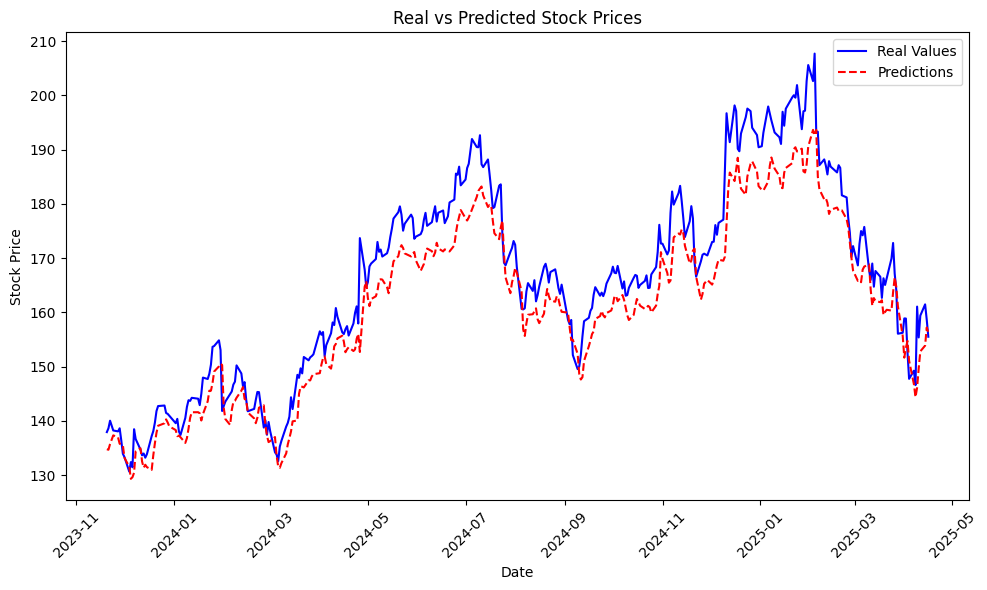

RNN | REV – Epsilon 0.05 – MAE: 5.3106 | SIM: 0.9998


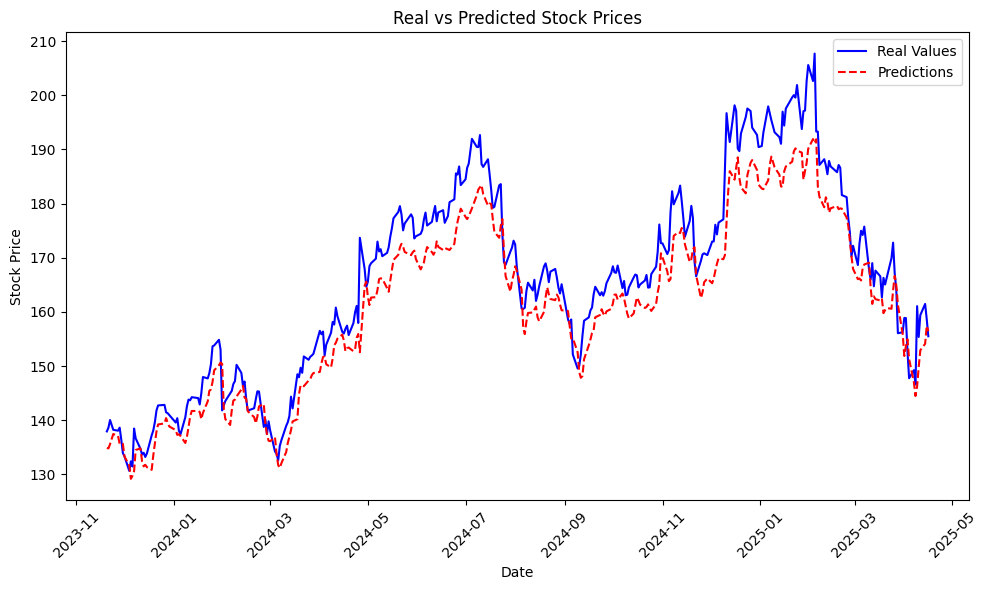

RNN | REV – Epsilon 0.10 – MAE: 5.3586 | SIM: 0.9997


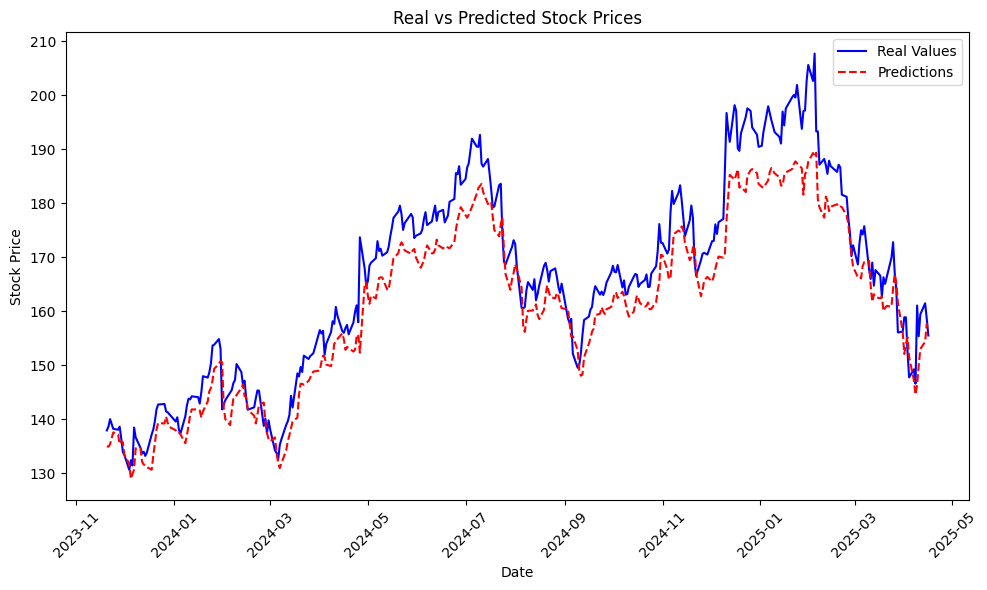

RNN | REV – Epsilon 0.20 – MAE: 6.1506 | SIM: 0.9995


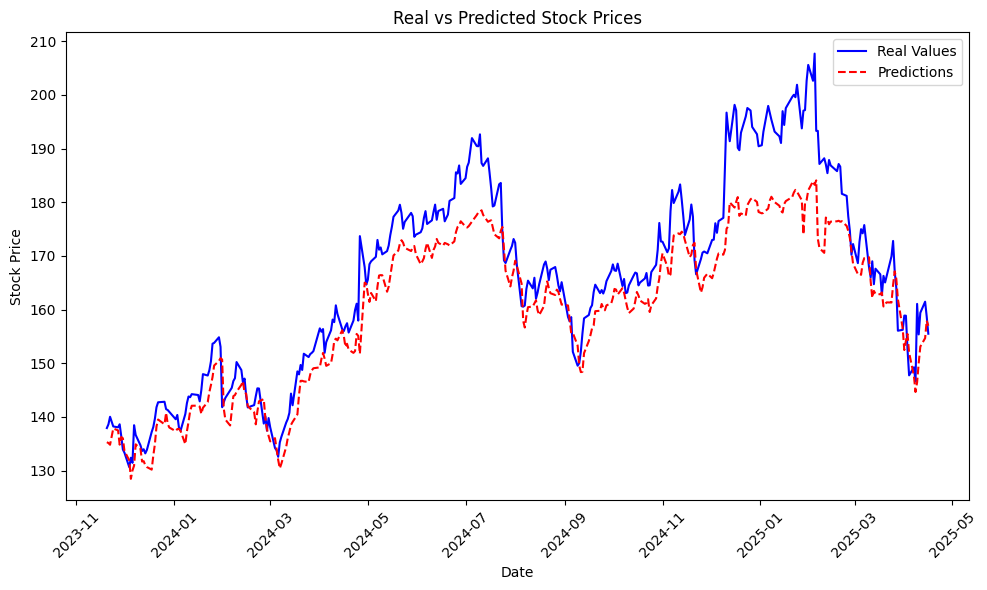

In [131]:
from attack.rev import reverse_forecast_attack

results_rev_rnn = reverse_forecast_attack(
    model_google_rnn_rev, model_google_rnn,
    test_loader_rev, test_loader,
    epsilons,
    price_min, price_max
)

for esp, (true_vals, preds) in results_rev_rnn.items():
  log_and_plot_predictions(
      true_values=true_vals,
      predictions=preds,
      test_dates=test_dates,
      true_values_rolling=None,
      predictions_rolling=None,
      model_name='RNN',
      attack_name='REV',
      epsilon=esp,
      res_tab=res_tab,
      similarity_fn=scalar_similarity,
      google=True
  )

In [132]:
display(res_tab)

Attack              NA      PAST       REV                               
ε                 0.00      0.00      0.01      0.05      0.10       0.20
Model Metric                                                             
LSTM  MAE     5.018705  3.084825  5.072169  5.842518  7.620422  12.551338
      RMSE    6.179676  4.066869  6.284750  7.415823  9.891750  16.168176
      SIM     0.999626  0.999701  0.999619  0.999412  0.998756   0.996163
RNN   MAE     5.417097  3.378071  5.387869  5.310602  5.358563   6.150604
      RMSE    6.409823  4.435154  6.381451  6.317599  6.458412   7.876784
      SIM     0.999765  0.999831  0.999765  0.999763  0.999738   0.999541
GRU   MAE          NaN       NaN       NaN       NaN       NaN        NaN
      RMSE         NaN       NaN       NaN       NaN       NaN        NaN
      SIM          NaN       NaN       NaN       NaN       NaN        NaN

In [133]:
from models.gru import SimpleGRU
model_google_gru = SimpleGRU(input_size=5, hidden_size=64, output_size=1, num_layers=2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_google_gru.parameters(), lr=0.001)
num_epochs = 30
train_model(model_google_gru, loss_fn, optimizer, num_epochs, train_loader)

Epoch [1/30], Train Loss: 0.0364
Epoch [2/30], Train Loss: 0.0030
Epoch [3/30], Train Loss: 0.0007
Epoch [4/30], Train Loss: 0.0006
Epoch [5/30], Train Loss: 0.0005
Epoch [6/30], Train Loss: 0.0005
Epoch [7/30], Train Loss: 0.0005
Epoch [8/30], Train Loss: 0.0005
Epoch [9/30], Train Loss: 0.0004
Epoch [10/30], Train Loss: 0.0004
Epoch [11/30], Train Loss: 0.0004
Epoch [12/30], Train Loss: 0.0004
Epoch [13/30], Train Loss: 0.0004
Epoch [14/30], Train Loss: 0.0004
Epoch [15/30], Train Loss: 0.0004
Epoch [16/30], Train Loss: 0.0004
Epoch [17/30], Train Loss: 0.0004
Epoch [18/30], Train Loss: 0.0004
Epoch [19/30], Train Loss: 0.0003
Epoch [20/30], Train Loss: 0.0003
Epoch [21/30], Train Loss: 0.0003
Epoch [22/30], Train Loss: 0.0003
Epoch [23/30], Train Loss: 0.0004
Epoch [24/30], Train Loss: 0.0003
Epoch [25/30], Train Loss: 0.0003
Epoch [26/30], Train Loss: 0.0003
Epoch [27/30], Train Loss: 0.0003
Epoch [28/30], Train Loss: 0.0003
Epoch [29/30], Train Loss: 0.0003
Epoch [30/30], Train Lo

GRU | NA – Epsilon 0.00 – MAE: 3.4972 | SIM: 0.9998


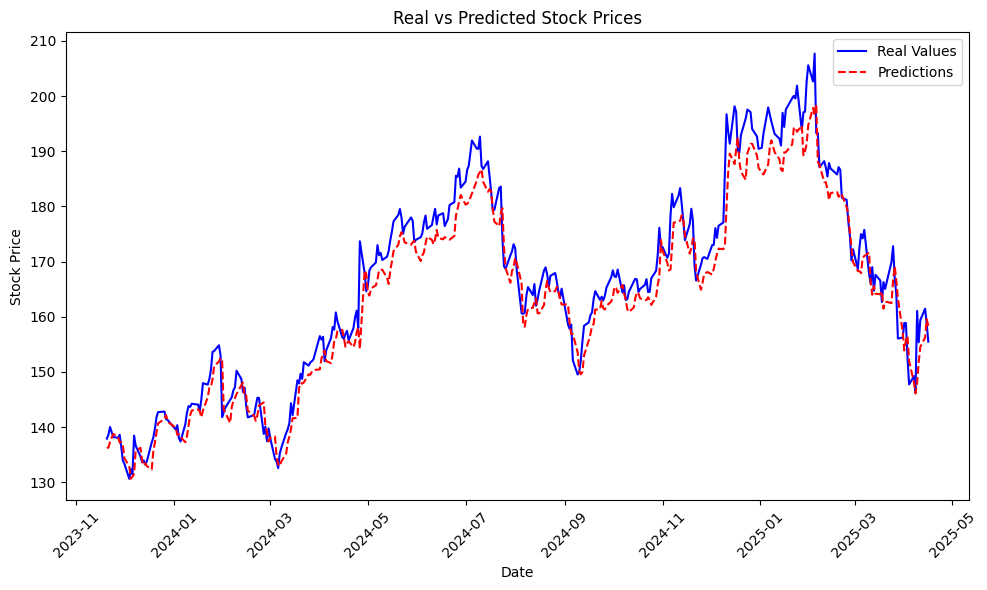

In [134]:
results_gru = evaluate_model_google(model_google_gru, test_loader, dates, train_size)

real_values_gru = results_gru['real_values']
predicted_values_gru = results_gru['predicted_values']
test_dates = results_gru['test_dates']

true_values_denorm_gru = real_values_gru * (price_max - price_min) + price_min
predictions_denorm_gru = predicted_values_gru * (price_max - price_min) + price_min

log_and_plot_predictions(
    true_values=true_values_denorm_gru,
    predictions=predictions_denorm_gru,
    test_dates=test_dates,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='GRU',
    attack_name='NA',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True
)

In [135]:
model_google_gru_rev = SimpleGRU(input_size=5, hidden_size=64, output_size=1, num_layers=2)
optimizer_rev = torch.optim.Adam(model_google_gru_rev.parameters(), lr=0.001)

train_model(model_google_gru_rev, loss_fn, optimizer_rev, num_epochs, train_loader_rev)

Epoch [1/30], Train Loss: 0.0201
Epoch [2/30], Train Loss: 0.0013
Epoch [3/30], Train Loss: 0.0006
Epoch [4/30], Train Loss: 0.0005
Epoch [5/30], Train Loss: 0.0004
Epoch [6/30], Train Loss: 0.0003
Epoch [7/30], Train Loss: 0.0003
Epoch [8/30], Train Loss: 0.0003
Epoch [9/30], Train Loss: 0.0003
Epoch [10/30], Train Loss: 0.0003
Epoch [11/30], Train Loss: 0.0002
Epoch [12/30], Train Loss: 0.0003
Epoch [13/30], Train Loss: 0.0002
Epoch [14/30], Train Loss: 0.0002
Epoch [15/30], Train Loss: 0.0002
Epoch [16/30], Train Loss: 0.0002
Epoch [17/30], Train Loss: 0.0002
Epoch [18/30], Train Loss: 0.0002
Epoch [19/30], Train Loss: 0.0002
Epoch [20/30], Train Loss: 0.0002
Epoch [21/30], Train Loss: 0.0002
Epoch [22/30], Train Loss: 0.0002
Epoch [23/30], Train Loss: 0.0002
Epoch [24/30], Train Loss: 0.0001
Epoch [25/30], Train Loss: 0.0002
Epoch [26/30], Train Loss: 0.0002
Epoch [27/30], Train Loss: 0.0002
Epoch [28/30], Train Loss: 0.0002
Epoch [29/30], Train Loss: 0.0001
Epoch [30/30], Train Lo

GRU | PAST – Epsilon 0.00 – MAE: 2.3144 | SIM: 0.9999


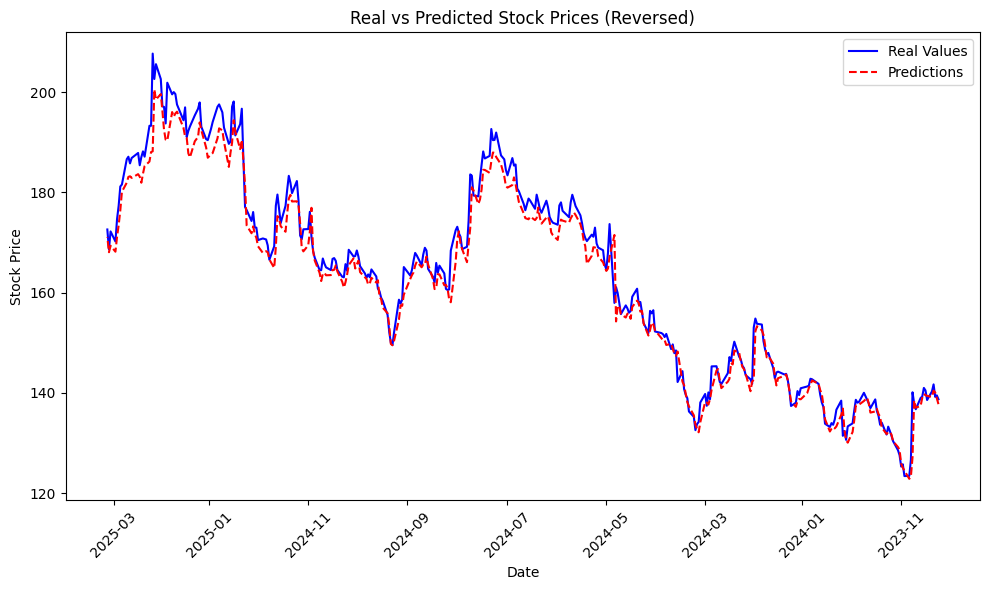

In [136]:
results_gru_rev = evaluate_model_google(model_google_gru_rev, test_loader_rev, dates_rev, train_size_rev)

real_values_gru_rev = results_gru_rev['real_values']
predicted_values_gru_rev = results_gru_rev['predicted_values']
test_dates_rev = results_gru_rev['test_dates']

min_len = min(len(test_dates_rev), len(real_values_gru_rev), len(predicted_values_gru_rev))
true_values_denorm_gru_rev = (real_values_gru_rev * (price_max_rev - price_min_rev) + price_min_rev)[:min_len]
predictions_denorm_gru_rev = (predicted_values_gru_rev * (price_max_rev - price_min_rev) + price_min_rev)[:min_len]
test_dates_rev = test_dates_rev[:min_len]

log_and_plot_predictions(
    true_values=true_values_denorm_gru_rev,
    predictions=predictions_denorm_gru_rev,
    test_dates=test_dates_rev,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='GRU',
    attack_name='PAST',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True,
    reverse=True
)

GRU | REV – Epsilon 0.01 – MAE: 3.4300 | SIM: 0.9998


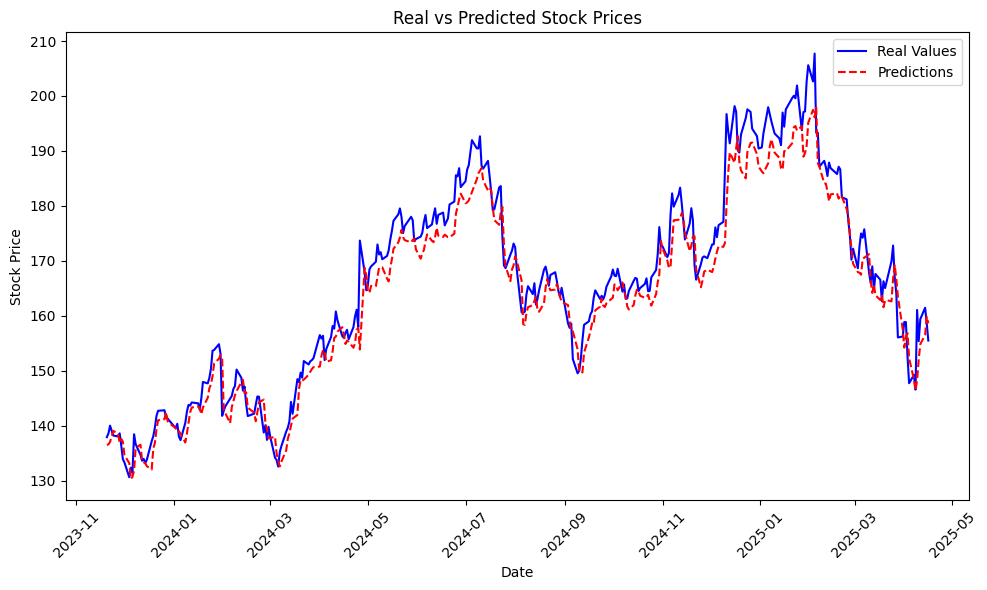

GRU | REV – Epsilon 0.05 – MAE: 3.3225 | SIM: 0.9998


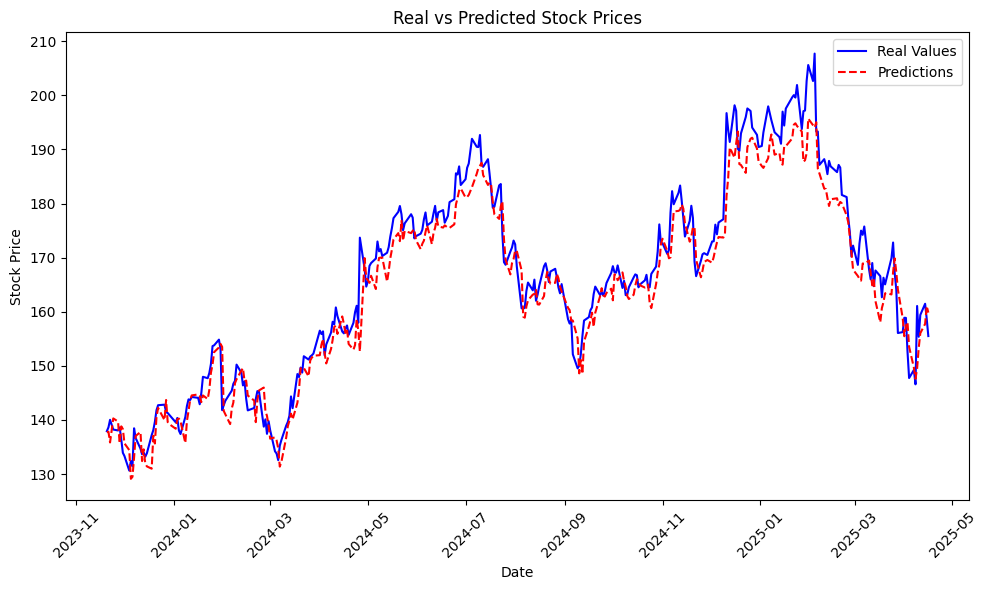

GRU | REV – Epsilon 0.10 – MAE: 3.6515 | SIM: 0.9996


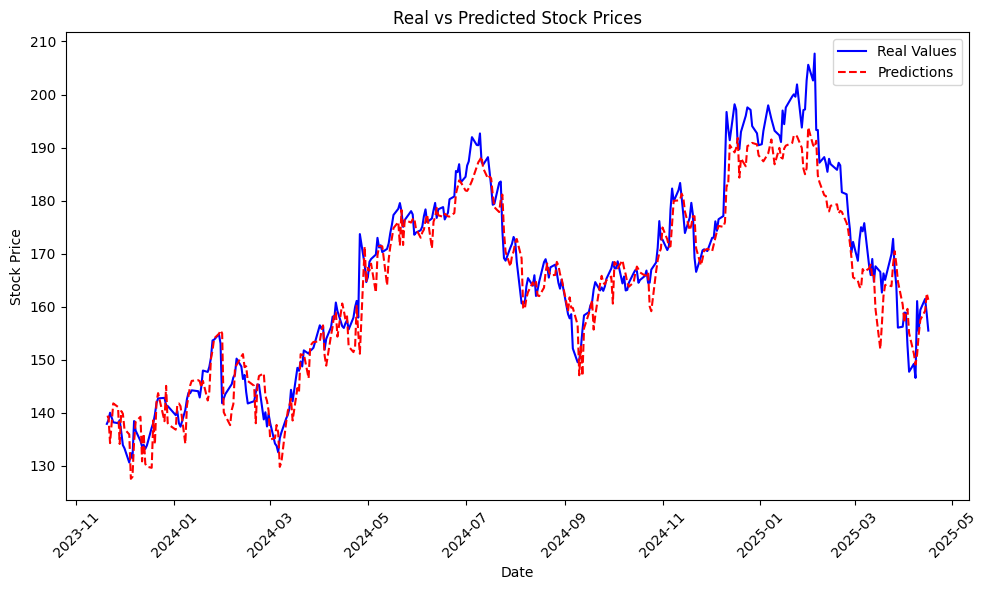

GRU | REV – Epsilon 0.20 – MAE: 5.9561 | SIM: 0.9990


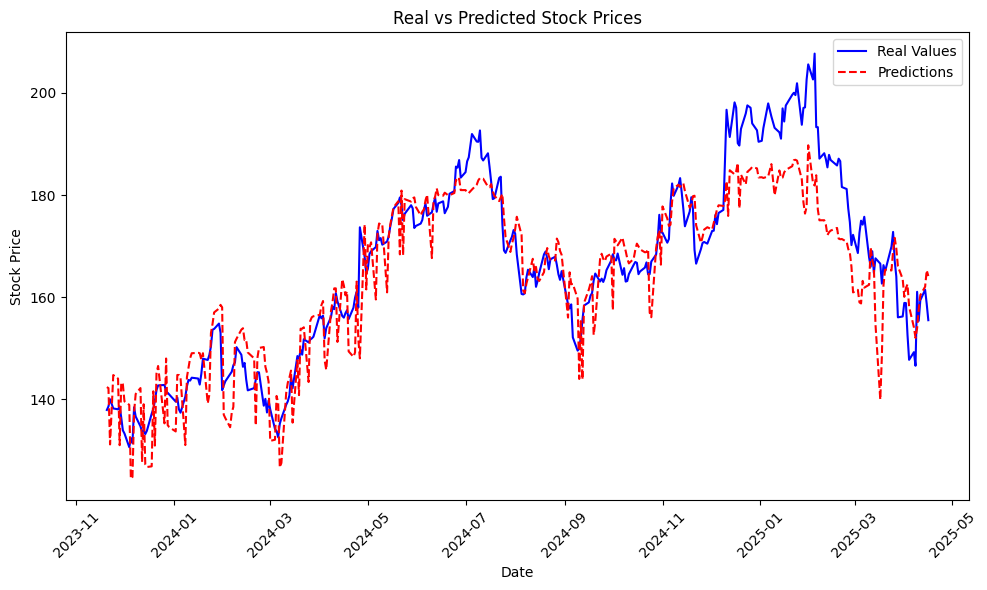

In [137]:
results_rev_gru = reverse_forecast_attack(
    model_google_gru_rev, model_google_gru,
    test_loader_rev, test_loader,
    epsilons,
    price_min, price_max
)

for esp, (true_vals, preds) in results_rev_gru.items():
  log_and_plot_predictions(
      true_values=true_vals,
      predictions=preds,
      test_dates=test_dates,
      true_values_rolling=None,
      predictions_rolling=None,
      model_name='GRU',
      attack_name='REV',
      epsilon=esp,
      res_tab=res_tab,
      similarity_fn=scalar_similarity,
      google=True
  )

In [138]:
display(res_tab)

Attack              NA      PAST       REV                               
ε                 0.00      0.00      0.01      0.05      0.10       0.20
Model Metric                                                             
LSTM  MAE     5.018705  3.084825  5.072169  5.842518  7.620422  12.551338
      RMSE    6.179676  4.066869  6.284750  7.415823  9.891750  16.168176
      SIM     0.999626  0.999701  0.999619  0.999412  0.998756   0.996163
RNN   MAE     5.417097  3.378071  5.387869  5.310602  5.358563   6.150604
      RMSE    6.409823  4.435154  6.381451  6.317599  6.458412   7.876784
      SIM     0.999765  0.999831  0.999765  0.999763  0.999738   0.999541
GRU   MAE     3.497228  2.314364  3.430037  3.322527  3.651544   5.956095
      RMSE    4.420301  3.258162  4.353401  4.309304  4.848167   7.587980
      SIM     0.999793  0.999879  0.999792  0.999762  0.999643   0.999024

# CLASIC FGSM JUST FOR THE EXPERIMENTATION

In [139]:
def fgsm_attack(model, data_loader, epsilon, price_min, price_max):
    model.eval()
    adv_predictions = []
    true_values = []

    for x, y in data_loader:
        x = x.clone().detach().requires_grad_(True)
        y = y.clone().detach()

        # Forward pass
        output = model(x)
        loss = loss_fn(output, y)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # FGSM perturbation
        data_grad = x.grad.data
        sign_data_grad = data_grad.sign()
        perturbed_x = x + epsilon * sign_data_grad
        perturbed_x = torch.clamp(perturbed_x, 0, 1)

        # Predict with perturbed input
        with torch.no_grad():
            adv_output = model(perturbed_x)

        adv_predictions.extend(adv_output.squeeze().numpy())
        true_values.extend(y.squeeze().numpy())

    # Denormalize
    adv_predictions = np.array(adv_predictions) * (price_max - price_min) + price_min
    true_values = np.array(true_values) * (price_max - price_min) + price_min

    return true_values, adv_predictions


GRU | FGSM – Epsilon 0.01 – MAE: 4.9058 | SIM: 0.9997


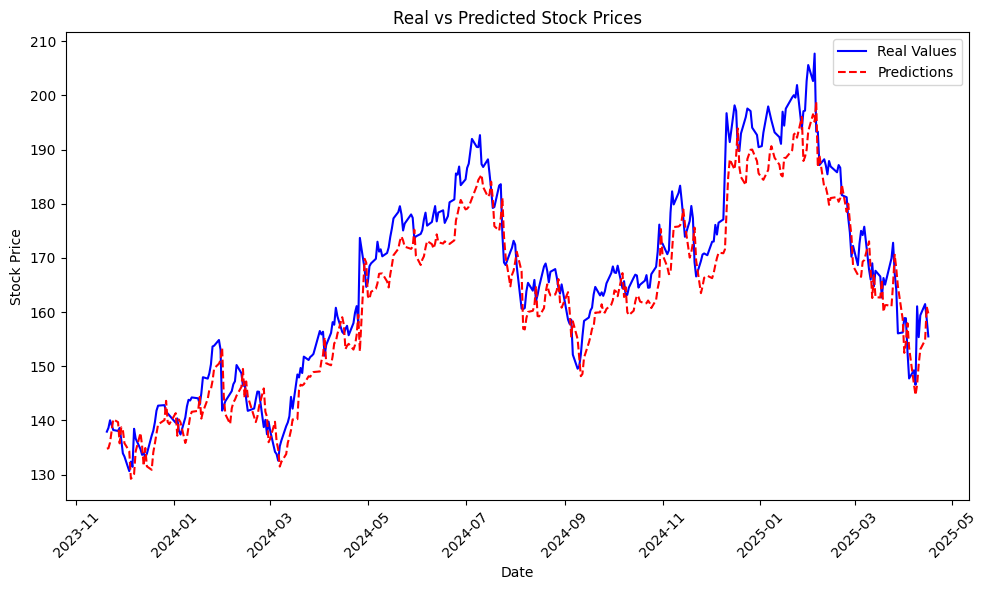

LSTM | FGSM – Epsilon 0.01 – MAE: 6.3177 | SIM: 0.9995


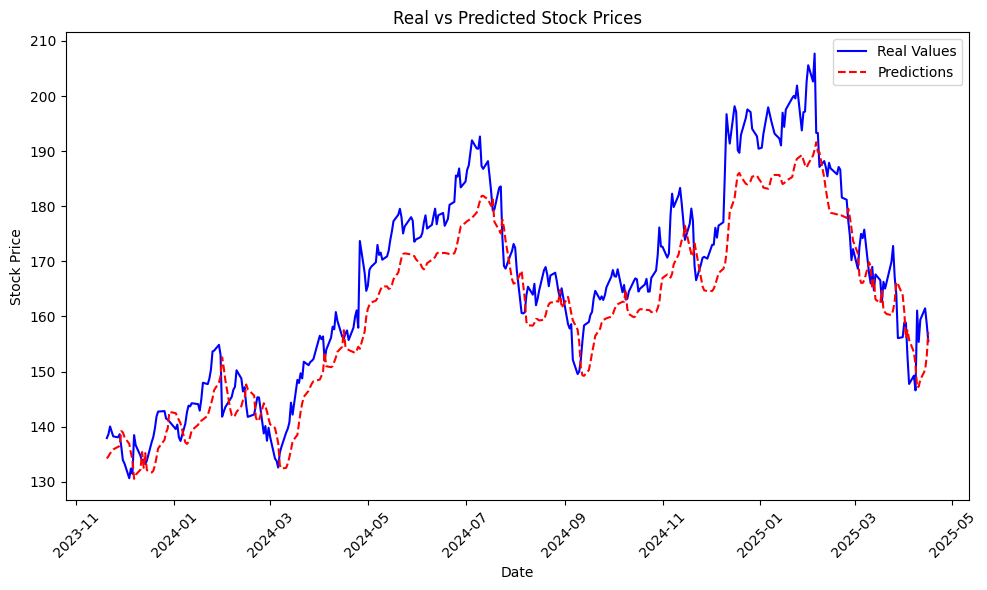

RNN | FGSM – Epsilon 0.01 – MAE: 6.9725 | SIM: 0.9997


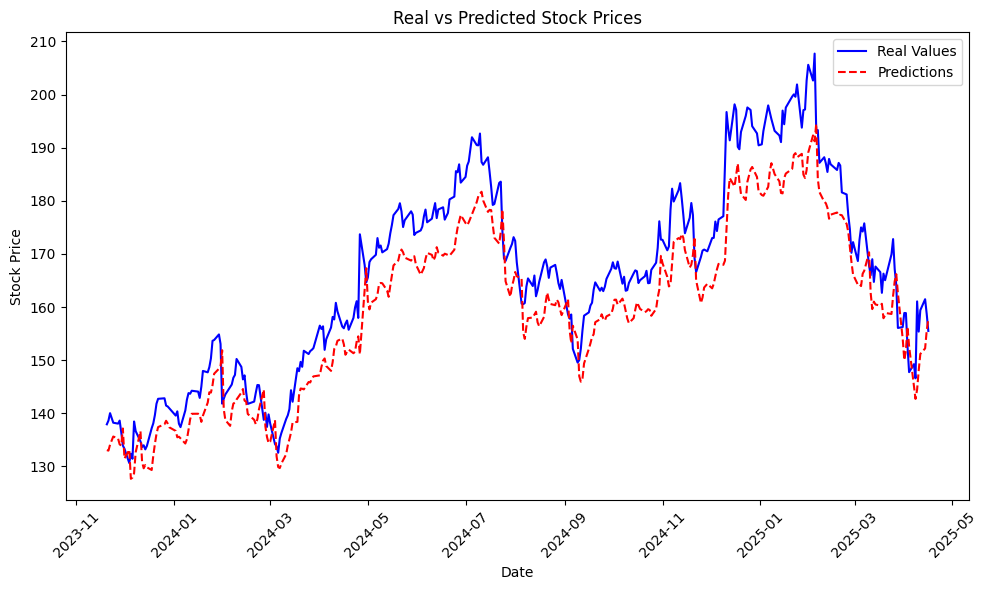

GRU | FGSM – Epsilon 0.10 – MAE: 17.5545 | SIM: 0.9962


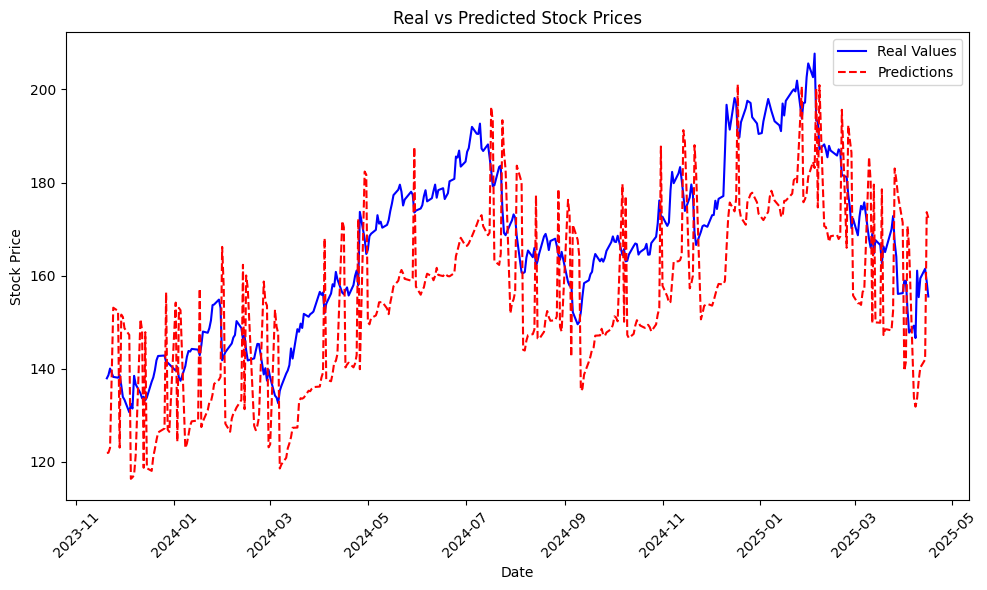

LSTM | FGSM – Epsilon 0.10 – MAE: 18.1520 | SIM: 0.9963


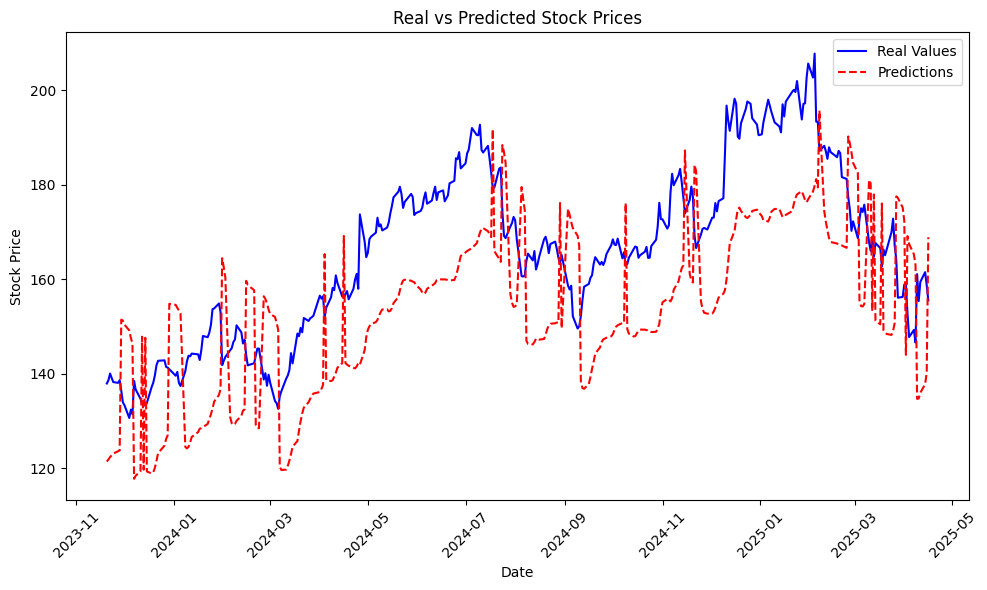

RNN | FGSM – Epsilon 0.10 – MAE: 21.0826 | SIM: 0.9980


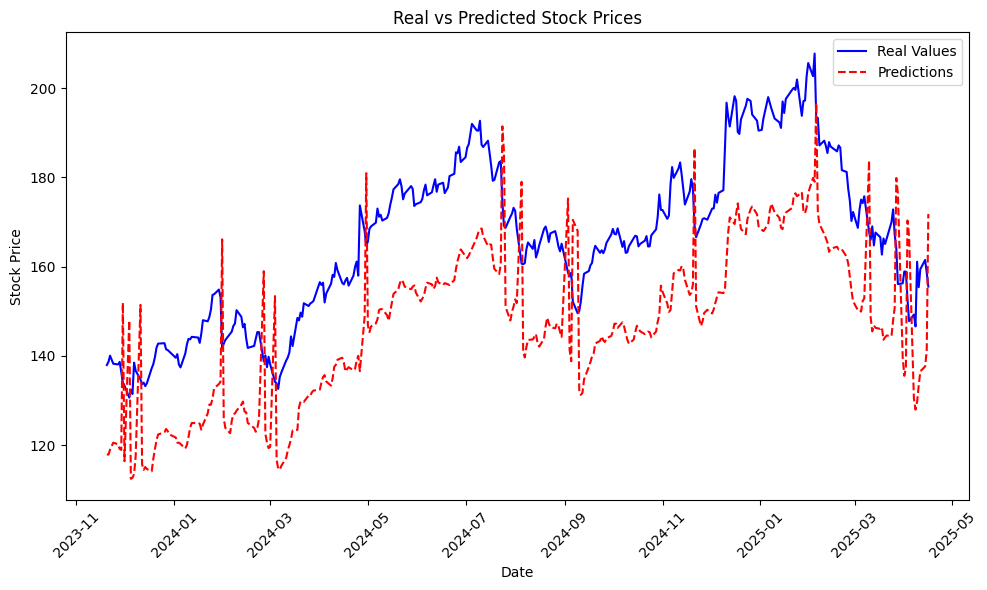

GRU | FGSM – Epsilon 0.20 – MAE: 31.2907 | SIM: 0.9868


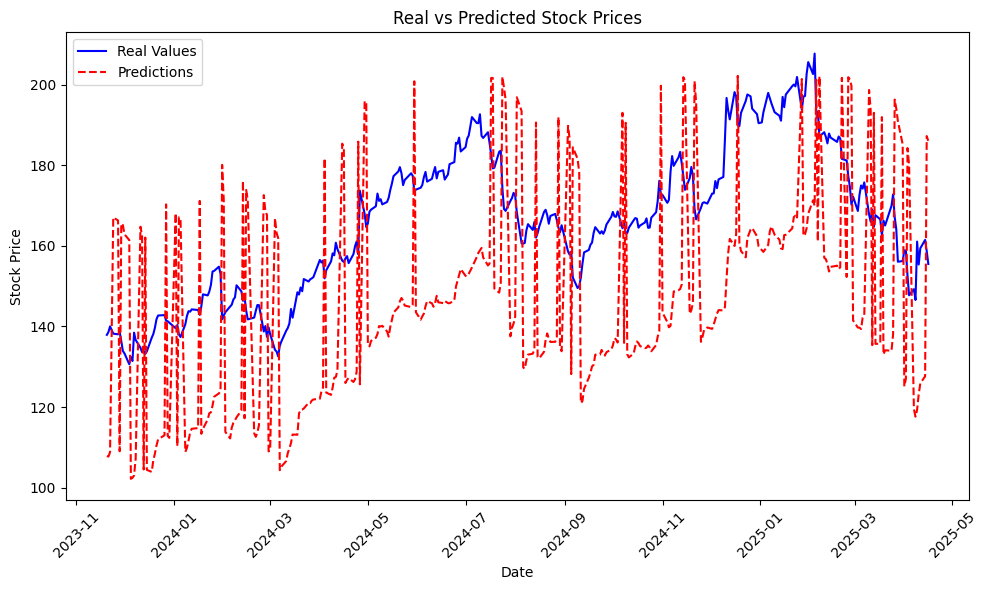

LSTM | FGSM – Epsilon 0.20 – MAE: 31.4039 | SIM: 0.9879


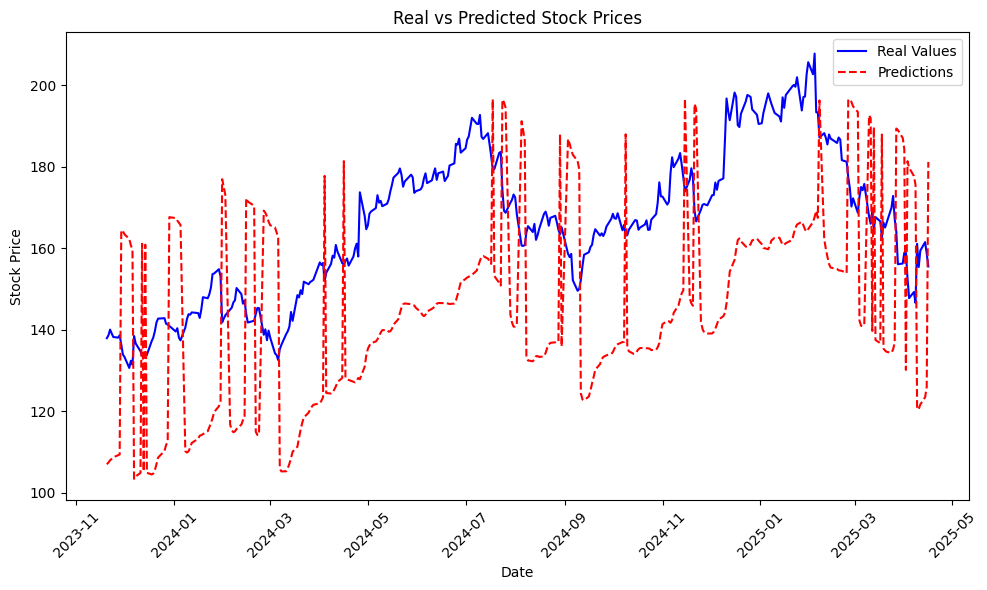

RNN | FGSM – Epsilon 0.20 – MAE: 36.7450 | SIM: 0.9927


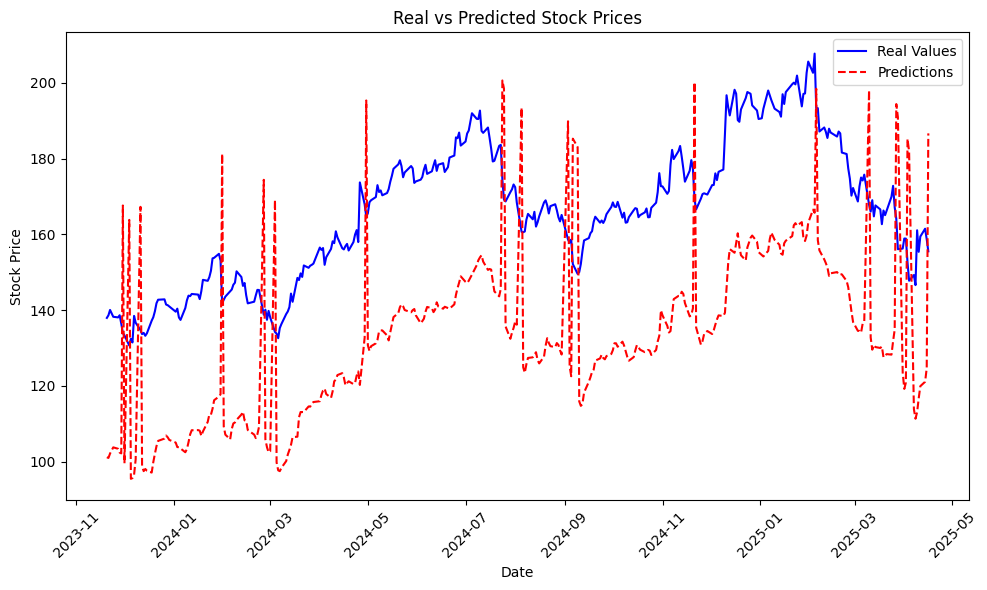

In [140]:
epsilons_fgsm = [0.01, 0.1, 0.2]

for eps in epsilons_fgsm:
    true_vals_fgsm, preds_fgsm = fgsm_attack(
        model_google_gru, test_loader, eps, price_min, price_max
    )

    log_and_plot_predictions(
        true_values=true_vals_fgsm,
        predictions=preds_fgsm,
        test_dates=test_dates,
        true_values_rolling=None,
        predictions_rolling=None,
        model_name='GRU',
        attack_name='FGSM',
        epsilon=eps,
        res_tab=res_tab,
        similarity_fn=scalar_similarity,
        google=True
    )

    true_vals_fgsm, preds_fgsm = fgsm_attack(
        model_google, test_loader, eps, price_min, price_max
    )

    log_and_plot_predictions(
        true_values=true_vals_fgsm,
        predictions=preds_fgsm,
        test_dates=test_dates,
        true_values_rolling=None,
        predictions_rolling=None,
        model_name='LSTM',
        attack_name='FGSM',
        epsilon=eps,
        res_tab=res_tab,
        similarity_fn=scalar_similarity,
        google=True
    )

    true_vals_fgsm, preds_fgsm = fgsm_attack(
        model_google_rnn, test_loader, eps, price_min, price_max
    )

    log_and_plot_predictions(
        true_values=true_vals_fgsm,
        predictions=preds_fgsm,
        test_dates=test_dates,
        true_values_rolling=None,
        predictions_rolling=None,
        model_name='RNN',
        attack_name='FGSM',
        epsilon=eps,
        res_tab=res_tab,
        similarity_fn=scalar_similarity,
        google=True
    )


In [141]:
display(res_tab)

Attack              NA      PAST       REV                                 \
ε                 0.00      0.00      0.01      0.05      0.10       0.20   
Model Metric                                                                
LSTM  MAE     5.018705  3.084825  5.072169  5.842518  7.620422  12.551338   
      RMSE    6.179676  4.066869  6.284750  7.415823  9.891750  16.168176   
      SIM     0.999626  0.999701  0.999619  0.999412  0.998756   0.996163   
RNN   MAE     5.417097  3.378071  5.387869  5.310602  5.358563   6.150604   
      RMSE    6.409823  4.435154  6.381451  6.317599  6.458412   7.876784   
      SIM     0.999765  0.999831  0.999765  0.999763  0.999738   0.999541   
GRU   MAE     3.497228  2.314364  3.430037  3.322527  3.651544   5.956095   
      RMSE    4.420301  3.258162  4.353401  4.309304  4.848167   7.587980   
      SIM     0.999793  0.999879  0.999792  0.999762  0.999643   0.999024   

Attack            FGSM                        
ε                 0.01       0.10       0.20  
Model Metric                                  
LSTM  MAE     6.317659  18.152014  31.403931  
      RMSE    7.262242  18.488847  31.660598  
      SIM     0.999495   0.996319   0.987933  
RNN   MAE     6.972453  21.082600  36.744972  
      RMSE    7.754845  21.332065  36.913395  
      SIM     0.999713   0.998043   0.992747  
GRU   MAE     4.905809  17.554485  31.290730  
      RMSE    5.596992  17.776065  31.502976  
      SIM     0.999675   0.996226   0.986784

Résult interpretation :


# Simple test using model_rev != model

RNN | REV_NO_EQUAL – Epsilon 0.01 – MAE: 5.4026 | SIM: 0.9998


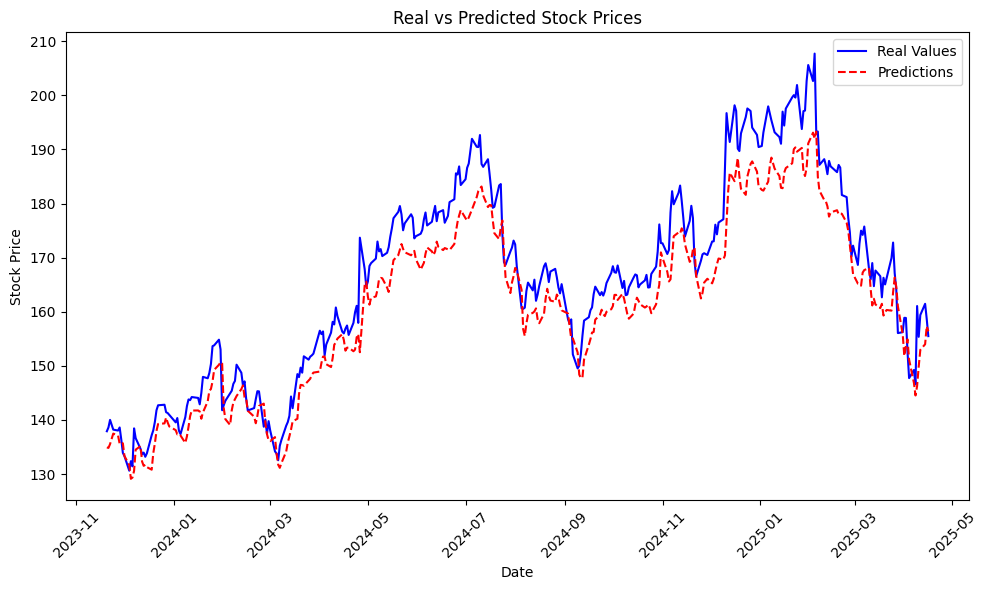

RNN | REV_NO_EQUAL – Epsilon 0.05 – MAE: 5.4327 | SIM: 0.9997


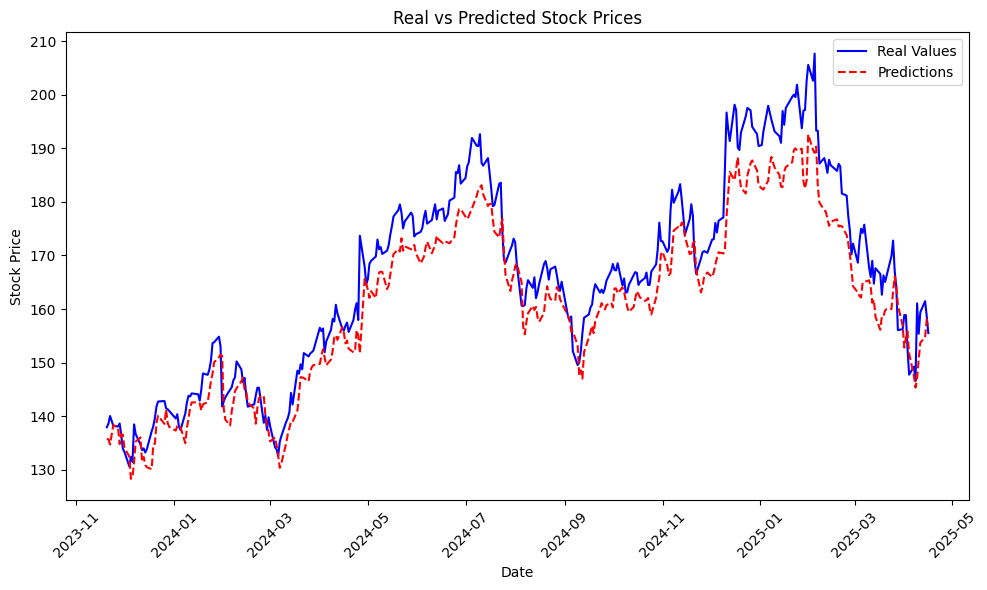

RNN | REV_NO_EQUAL – Epsilon 0.10 – MAE: 5.6727 | SIM: 0.9996


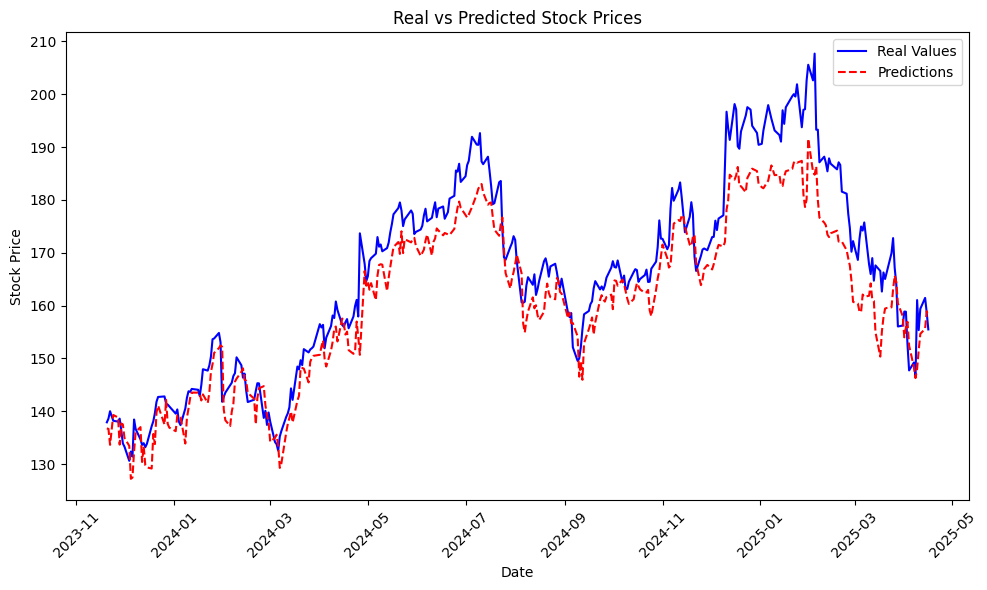

RNN | REV_NO_EQUAL – Epsilon 0.20 – MAE: 6.9436 | SIM: 0.9990


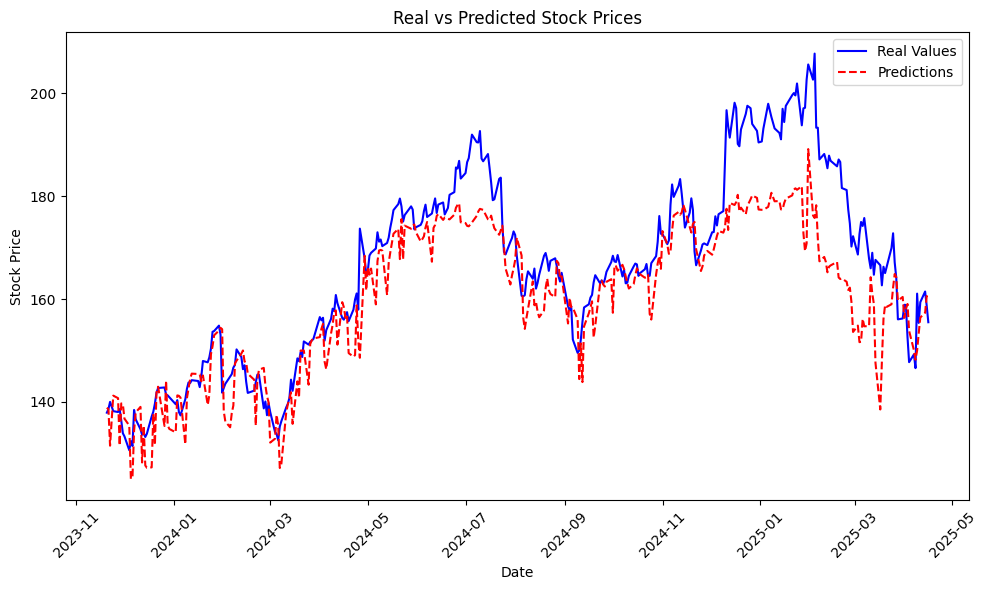

In [149]:
# I try to attaque model LSTM with GRU_rev to see what append (and GRU with LSTM,etc...)
results_rev_test = reverse_forecast_attack(
    model_google_gru_rev, model_google_rnn,
    test_loader_rev, test_loader,
    epsilons,
    price_min, price_max
)

for esp, (true_vals, preds) in results_rev_test.items():
  log_and_plot_predictions(
      true_values=true_vals,
      predictions=preds,
      test_dates=test_dates,
      true_values_rolling=None,
      predictions_rolling=None,
      model_name='RNN',
      attack_name='REV_NO_EQUAL',
      epsilon=esp,
      res_tab=res_tab,
      similarity_fn=scalar_similarity,
      google=True
  )

In [150]:
display(res_tab)

Attack              NA      PAST       REV                                 \
ε                 0.00      0.00      0.01      0.05      0.10       0.20   
Model Metric                                                                
LSTM  MAE     5.018705  3.084825  5.072169  5.842518  7.620422  12.551338   
      RMSE    6.179676  4.066869  6.284750  7.415823  9.891750  16.168176   
      SIM     0.999626  0.999701  0.999619  0.999412  0.998756   0.996163   
RNN   MAE     5.417097  3.378071  5.387869  5.310602  5.358563   6.150604   
      RMSE    6.409823  4.435154  6.381451  6.317599  6.458412   7.876784   
      SIM     0.999765  0.999831  0.999765  0.999763  0.999738   0.999541   
GRU   MAE     3.497228  2.314364  3.430037  3.322527  3.651544   5.956095   
      RMSE    4.420301  3.258162  4.353401  4.309304  4.848167   7.587980   
      SIM     0.999793  0.999879  0.999792  0.999762  0.999643   0.999024   

Attack            FGSM                       REV_NO_EQUAL                      \
ε                 0.01       0.10       0.20         0.01      0.05      0.10   
Model Metric                                                                    
LSTM  MAE     6.317659  18.152014  31.403931     5.076159  5.447963  6.111455   
      RMSE    7.262242  18.488847  31.660598     6.261239  6.721706  7.644287   
      SIM     0.999495   0.996319   0.987933     0.999624  0.999587  0.999464   
RNN   MAE     6.972453  21.082600  36.744972     5.402643  5.432680  5.672652   
      RMSE    7.754845  21.332065  36.913395     6.408885  6.531624  7.066907   
      SIM     0.999713   0.998043   0.992747     0.999763  0.999728  0.999612   
GRU   MAE     4.905809  17.554485  31.290730     3.634371  4.343567  5.577318   
      RMSE    5.596992  17.776065  31.502976     4.568397  5.304962  6.542042   
      SIM     0.999675   0.996226   0.986784     0.999791  0.999769  0.999701   

Attack                   
ε                  0.20  
Model Metric             
LSTM  MAE      8.040307  
      RMSE    10.678209  
      SIM      0.998846  
RNN   MAE      6.943598  
      RMSE     9.535266  
      SIM      0.999025  
GRU   MAE      8.946065  
      RMSE    10.037439  
      SIM      0.999364

We observe something really interesting :
* The more accurate the proxy model is, the lower the resulting MAE tends to be. In other words, when the proxy model is accurate, the attack becomes more stealthy, but slightly less aggressive in terms of prediction error.
* This is actually a good trade-off in time series attacks, where the objective is often to maximize disruption while remaining undetectable.
* That's also why, when we use a less accurate proxy (e.g., LSTM instead of GRU or RNN), the attack can result in a higher MAE meaning it's more aggressive but at the cost of being visually detectable.
* This is clearly visible in the plots: the more aggressive attacks often generate abnormal prediction curves, making the anomaly obvious.

* Also i don't know for the moment the real impact of using another model for proxy than the model we use for prediction? for exemple even when the proxy models achieve similar reverse prediction performance (i.e., same MAE), the resulting adversarial impact on the target model can vary significantly.
In particular, GRU-based proxy models tend to produce more effective attacks than RNNs, despite comparable accuracy.